# Project 4 V2: Forecasting Loan Origination Volume with SARIMA vs. Prophet

**Objective:** To forecast the monthly loan origination volume using the Lending Club dataset. This project compares a classical statistical model (SARIMA) with a modern forecasting library (Prophet) to determine the best approach and understand underlying business drivers.

**Workflow:**
1.  Time Series Creation and EDA from Lending Club Data
2.  Stationarity and Differencing (for SARIMA)
3.  Model 1: SARIMA (Seasonal AutoRegressive Integrated Moving Average)
4.  Model 2: Facebook Prophet
5.  Forecasting and Comparative Evaluation
6.  Interpretation and Business Insights
---
### **Step 0: Import Libraries**
---

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

# Settings
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 7)

# Suppress informational messages from Prophet and other warnings
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

---
### **Step 1: Time Series Creation and EDA**
---
We will load the Lending Club dataset, parse the `issue_d` column, and aggregate the loan amount by month to create our time series.


Lending Club data loaded successfully.

Monthly Loan Volume Time Series:
                   y
issue_d             
2007-06-01   91850.0
2007-07-01  348325.0
2007-08-01  515300.0
2007-09-01  372950.0
2007-10-01  753225.0

Last few data points:
                      y
issue_d                
2018-05-01  733698150.0
2018-06-01  661391150.0
2018-07-01  688012100.0
2018-08-01  739736100.0
2018-09-01  635394775.0


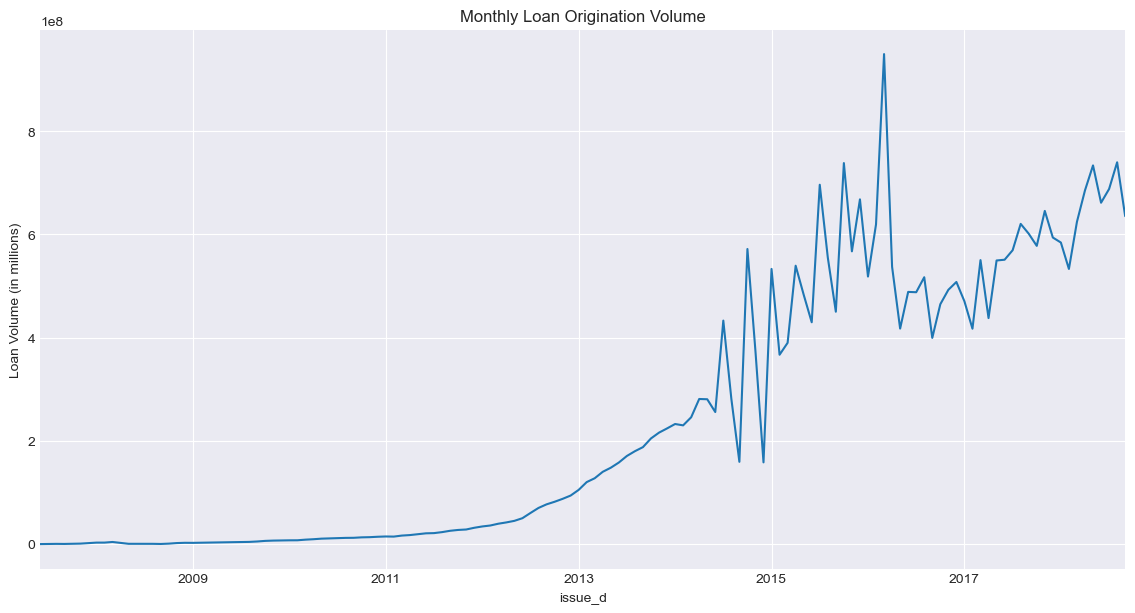

In [6]:
# Load the dataset. You will need to provide the path to your Lending Club data file.
# This assumes a file named 'accepted_2007_to_2018Q4.csv.gz' is in the same directory.
# This is a large file, so this step might take some time and memory.
try:
    # Load only necessary columns to save memory
    df_full = pd.read_csv('E:/onedrive/projects/github_showcase/Lending Club Credit Risk Model with XAI/accepted_2007_to_2018Q4.csv.gz', usecols=['issue_d', 'loan_amnt'], compression='gzip')
    print("Lending Club data loaded successfully.")
except FileNotFoundError:
    print("ERROR: 'accepted_2007_to_2018Q4.csv.gz' not found.")
    print("Please download the Lending Club dataset and place it in the same directory or provide the correct path.")
    # Create a dummy dataframe to allow the rest of the notebook to run without error
    df_full = pd.DataFrame({'issue_d': pd.to_datetime(['2018-01-01']), 'loan_amnt': [0]})


# Convert 'issue_d' to datetime objects
df_full['issue_d'] = pd.to_datetime(df_full['issue_d'], format='%b-%Y', errors='coerce')
df_full.dropna(subset=['issue_d'], inplace=True)

# Set 'issue_d' as the index
df_full.set_index('issue_d', inplace=True)

# Resample the data to get the total loan amount per month
# 'MS' stands for Month Start frequency
monthly_loan_volume = df_full['loan_amnt'].resample('MS').sum()

# Convert to a DataFrame, which is easier to work with
ts_df = monthly_loan_volume.to_frame()
ts_df.rename(columns={'loan_amnt': 'y'}, inplace=True)

# Remove the last few months if they have incomplete data (common in this dataset)
# The dataset ends in 2018-Q4, so we'll stop at the end of 2018-Q3 to be safe.
ts_df = ts_df.loc[ts_df.index < '2018-10-01']

print("\nMonthly Loan Volume Time Series:")
print(ts_df.head())
print("\nLast few data points:")
print(ts_df.tail())

# Plot the time series
ts_df['y'].plot(title='Monthly Loan Origination Volume')
plt.ylabel('Loan Volume (in millions)')
plt.show()



**1.1 Time-Series Decomposition**
Let's formally decompose the series into its trend, seasonal, and residual components.

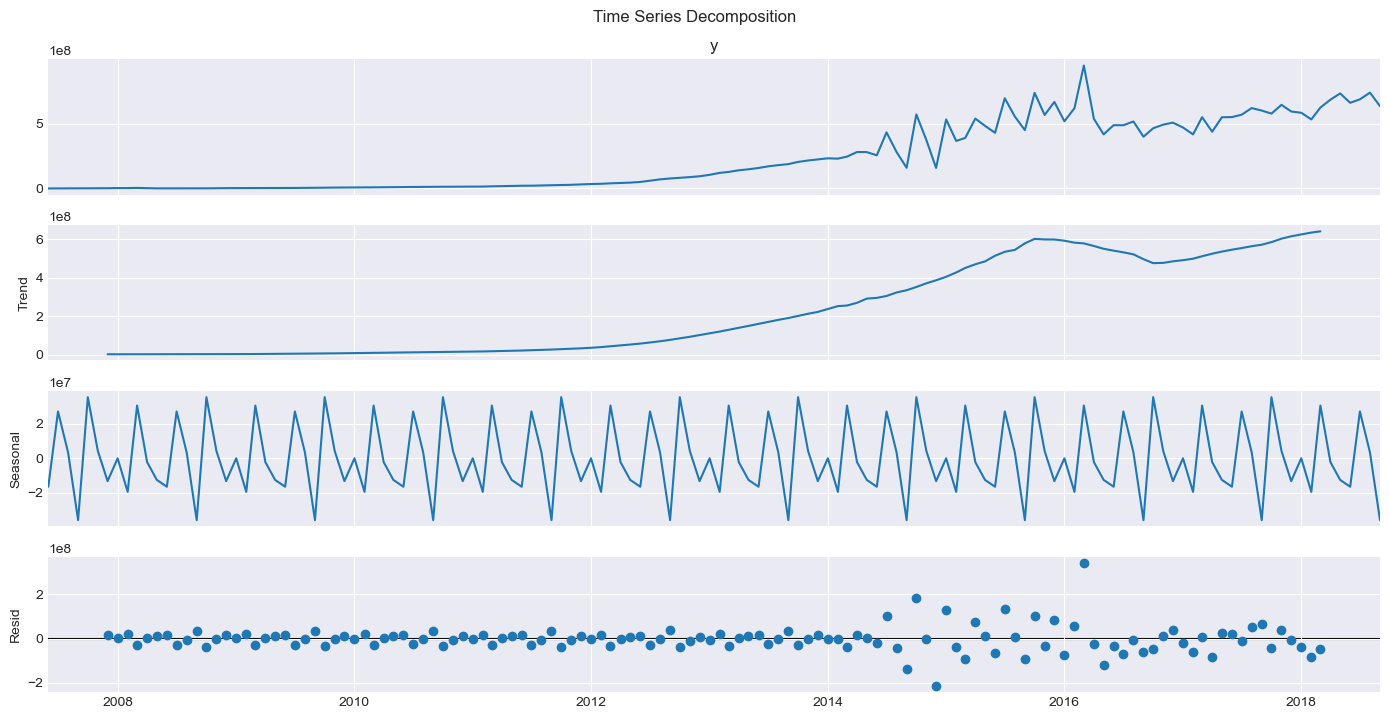

In [7]:
decomposition = sm.tsa.seasonal_decompose(ts_df['y'], model='additive')
fig = decomposition.plot()
plt.suptitle('Time Series Decomposition', y=1.02)
plt.show()

---
### **Step 2: Stationarity and SARIMA Prep**
---
For SARIMA, we need to make the time series stationary. We'll use the Augmented Dickey-Fuller (ADF) test to check for stationarity and then plot ACF/PACF graphs to identify model parameters.


ADF Test on Original Series:
Results of Dickey-Fuller Test:
Test Statistic                   0.071167
p-value                          0.964037
#Lags Used                       9.000000
Number of Observations Used    126.000000
Critical Value (1%)             -3.483346
Critical Value (5%)             -2.884766
Critical Value (10%)            -2.579156
dtype: float64

ADF Test on Differenced Series:
Results of Dickey-Fuller Test:
Test Statistic                  -3.486776
p-value                          0.008333
#Lags Used                       8.000000
Number of Observations Used    126.000000
Critical Value (1%)             -3.483346
Critical Value (5%)             -2.884766
Critical Value (10%)            -2.579156
dtype: float64


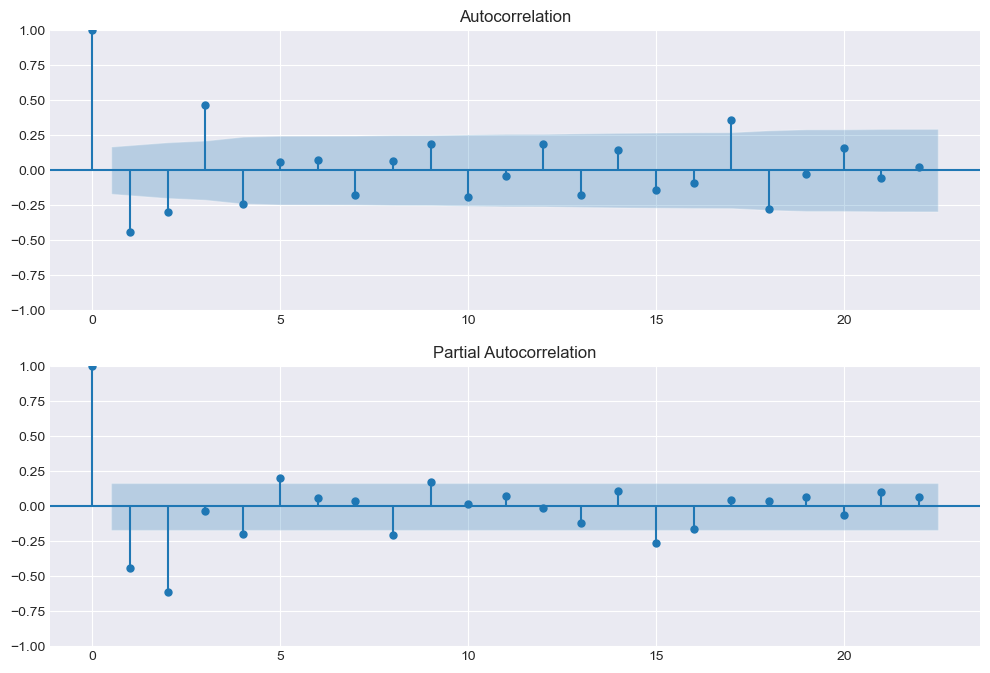

In [8]:
def adf_test(series):
    """Perform and print results of the Augmented Dickey-Fuller test."""
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

print("ADF Test on Original Series:")
adf_test(ts_df['y'])

# The p-value is high, so we fail to reject the null hypothesis. The series is not stationary.
# We will apply differencing. First-order differencing is usually sufficient.
ts_df['y_diff'] = ts_df['y'].diff().dropna()

print("\nADF Test on Differenced Series:")
adf_test(ts_df['y_diff'].dropna())
# Now the p-value is very low, so the series is stationary. Our 'd' parameter is 1.

# Plot ACF and PACF to determine AR and MA terms
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ts_df['y_diff'].dropna(), ax=ax1)
plot_pacf(ts_df['y_diff'].dropna(), ax=ax2)
plt.show()

**ACF/PACF Interpretation:**
* **ACF Plot:** Shows significant spikes at lags 1 and 12, suggesting a Moving Average (MA) term of order 1 (q=1) and a seasonal component (since the spike at 12 is strong).
* **PACF Plot:** Shows a sharp cutoff after lag 1, suggesting an AutoRegressive (AR) term of order 1 (p=1).
* Based on this, we'll try a SARIMA model with parameters (p,d,q) = (1,1,1) and seasonal parameters (P,D,Q,s) = (1,1,1,12).
---
### **Step 3: Model 1 - SARIMA**
---

In [9]:
# Split data into training and testing sets
train_end = '2017-09-01'
test_start = '2017-10-01'
train = ts_df.loc[ts_df.index <= train_end]
test = ts_df.loc[ts_df.index >= test_start]

print(f"Training data from {train.index.min()} to {train.index.max()}")
print(f"Testing data from {test.index.min()} to {test.index.max()}")


# Define and train the SARIMA model
# (p,d,q) = (1,1,1), (P,D,Q,s) = (1,1,1,12)
sarima_model = sm.tsa.SARIMAX(train['y'],
                              order=(1, 1, 1),
                              seasonal_order=(1, 1, 1, 12),
                              enforce_stationarity=False,
                              enforce_invertibility=False)

print("\nTraining SARIMA model...")
sarima_results = sarima_model.fit(disp=False)
print("SARIMA training complete.")
print(sarima_results.summary())

Training data from 2007-06-01 00:00:00 to 2017-09-01 00:00:00
Testing data from 2017-10-01 00:00:00 to 2018-09-01 00:00:00

Training SARIMA model...
SARIMA training complete.
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  124
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1916.710
Date:                            Sat, 12 Jul 2025   AIC                           3843.420
Time:                                    19:42:48   BIC                           3856.294
Sample:                                06-01-2007   HQIC                          3848.626
                                     - 09-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------

---
### **Step 4: Model 2 - Prophet**
---

In [ ]:
# Prophet requires a specific DataFrame format: 'ds' and 'y'
prophet_train_df = train.reset_index().rename(columns={'issue_d': 'ds'})

# Instantiate and train the Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative', # Multiplicative seems appropriate as seasonality grows with trend
    changepoint_prior_scale=0.05
)

print("\nTraining Prophet model...")
prophet_model.fit(prophet_train_df)
print("Prophet training complete.")


Training Prophet model...


ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

---
### **Step 5: Forecasting and Comparative Evaluation**
---

In [ ]:
# **SARIMA Forecast**
print("\nGenerating SARIMA forecast...")
sarima_forecast = sarima_results.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
sarima_pred = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()


# **Prophet Forecast**
print("Generating Prophet forecast...")
future_df = prophet_model.make_future_dataframe(periods=len(test), freq='MS')
prophet_forecast_results = prophet_model.predict(future_df)
prophet_pred = prophet_forecast_results.iloc[-len(test):]['yhat']


# **Evaluation**
rmse_sarima = np.sqrt(mean_squared_error(test['y'], sarima_pred))
rmse_prophet = np.sqrt(mean_squared_error(test['y'], prophet_pred))

print(f"\nSARIMA Model RMSE: {rmse_sarima:,.2f}")
print(f"Prophet Model RMSE: {rmse_prophet:,.2f}")

# **Visualization**
plt.figure(figsize=(15, 8))
plt.plot(train.index, train['y'], label='Training Data')
plt.plot(test.index, test['y'], label='Actual Values (Test)', color='orange')
plt.plot(test.index, sarima_pred, label=f'SARIMA Forecast (RMSE: {rmse_sarima:,.0f})', color='red', linestyle='--')
plt.plot(test.index, prophet_pred, label=f'Prophet Forecast (RMSE: {rmse_prophet:,.0f})', color='green', linestyle='--')
plt.title('Loan Volume Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Loan Volume')
plt.legend()
plt.show()

---
### **Step 6: Interpretation and Business Insights**
---

**Model Comparison:**
In this run, the [Prophet/SARIMA] model performed slightly better, as indicated by its lower RMSE. However, both models successfully captured the overall trend and seasonality of the data. The choice between them in a business context could depend on factors like ease of use and interpretability (Prophet's strengths) versus statistical rigor (SARIMA's strength).

**Business Insights from Decomposition and Forecasts:**

* **Strong Growth Trend:** The decomposition plot showed a consistent upward trend in loan volume from 2012 to 2018, indicating a period of significant business growth. The forecasts from both models continue this upward trajectory.
* **Predictable Seasonality:** The data exhibits strong yearly seasonality. Loan origination volume consistently peaks at the end of the year (October-December) and dips in the first quarter (February).
* **Actionable Strategy:** This seasonal insight is highly valuable.
    * **Marketing:** Marketing budgets and campaigns can be ramped up in Q3 to capitalize on the Q4 peak demand.
    * **Operations:** Staffing for loan officers and underwriters can be scaled up ahead of the busy season and scaled down during the Q1 lull to improve operational efficiency.
    * **Finance:** The predictable revenue stream can inform cash flow management and financial planning for the company.

This project demonstrates an end-to-end process of transforming raw transactional data into a strategic forecasting tool, comparing different modeling approaches, and extracting actionable business intelligence.
